Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for test
import sklearn 
from pylab import rcParams


#для отображения всех данных из pd (без ...)
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Загрузка данных

In [2]:
START_DATA = pd.read_csv ('train.zip', header=[0, 1])

Просто смотрю на формат данных

In [3]:
START_DATA.shape
START_DATA.columns
#START_DATA.tail()
#print(START_DATA.dtypes)

MultiIndex([(   'timestamp_second',   'Unnamed: 0_level_1'),
            (        'bid_price_0',              'nunique'),
            (        'bid_price_0',                 'mean'),
            (        'bid_price_0',               'median'),
            (        'bid_price_0',                  'std'),
            (        'bid_price_0',                  'min'),
            (        'bid_price_0',                  'max'),
            (        'bid_price_0',                'first'),
            (        'bid_price_0',                 'last'),
            (     'bid_quantity_0',                  'sum'),
            ...
            ('sell_trade_quantity',              'nunique'),
            ('sell_trade_quantity',                 'mean'),
            ('sell_trade_quantity',               'median'),
            ('sell_trade_quantity',                  'std'),
            ('sell_trade_quantity',                  'min'),
            ('sell_trade_quantity',                  'max'),
        

In [4]:
#basic_data = START_DATA.bid_price_0["mean"].dropna()

In [5]:
START_DATA.bid_price_0["mean"].head()

0    44.183379
1    44.190000
2    44.187467
3    44.181038
4    44.213095
Name: mean, dtype: float64

Строю графики для bid, ask

<AxesSubplot:title={'center':'BID_0'}, ylabel='Цена, $'>

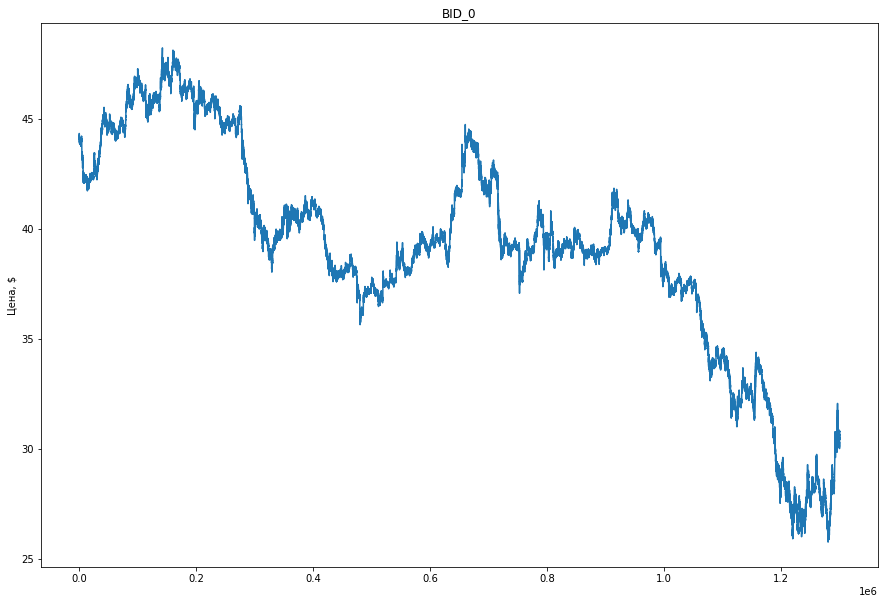

In [6]:
START_DATA.bid_price_0["mean"].plot(title = 'BID_0', xlabel = '', ylabel = 'Цена, $', figsize = (15, 10))

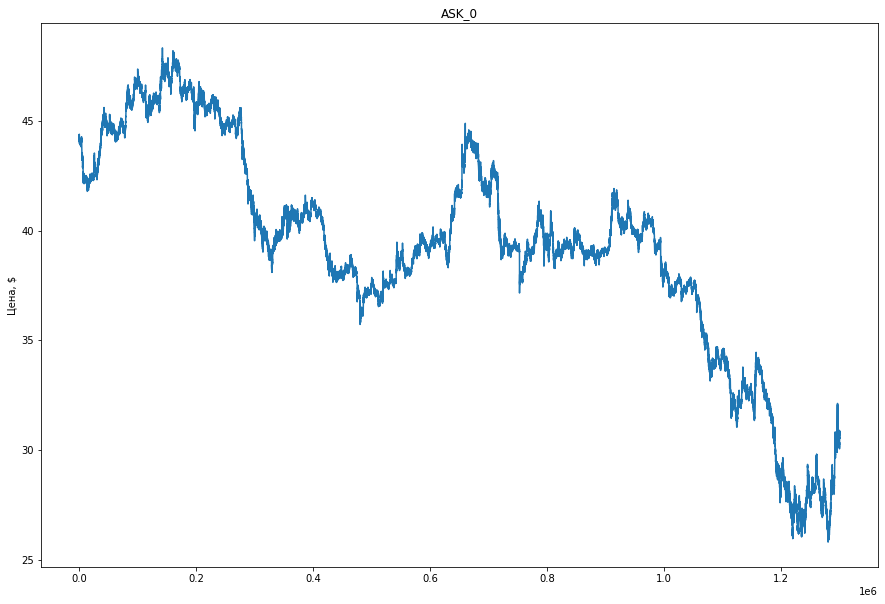

In [7]:
plt = START_DATA.ask_price_0["mean"].plot(title = 'ASK_0', xlabel = '', ylabel = 'Цена, $', figsize = (15, 10))

<AxesSubplot:ylabel='Цена, $'>

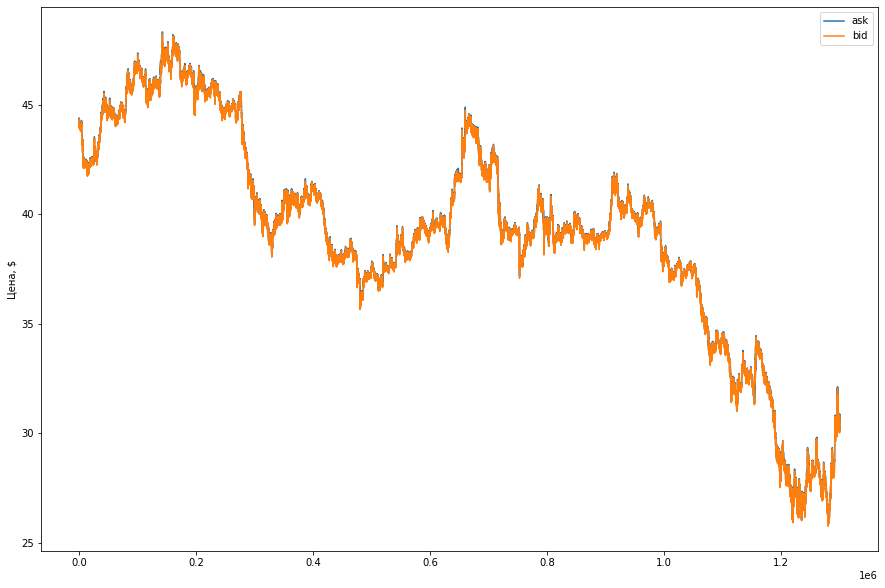

In [8]:
Ask_Bid_Graphs = pd.DataFrame(index = START_DATA.index)
Ask_Bid_Graphs['ask'] = START_DATA.ask_price_0["mean"]
Ask_Bid_Graphs['bid'] = START_DATA.bid_price_0["mean"]
Ask_Bid_Graphs.plot(ylabel = 'Цена, $', figsize = (15, 10))


Начало разработки моделей предсказания

Беру только нужные для предсказания поля из всех данных

In [9]:
Bid_mean_DataFrame = pd.DataFrame(data = {'mean_bid': START_DATA.bid_price_0["mean"], 'seconds':START_DATA.timestamp_second['Unnamed: 0_level_1']} )
Bid_mean_DataFrame = Bid_mean_DataFrame.set_index('seconds')
Bid_mean_DataFrame.tail

<bound method NDFrame.tail of           mean_bid
seconds           
0        44.183379
1        44.190000
2        44.187467
3        44.181038
4        44.213095
...            ...
1299995  30.777000
1299996  30.777000
1299997  30.780052
1299998  30.786015
1299999  30.804518

[1300000 rows x 1 columns]>

Разделяю данные на тренировочные и тестовые

In [10]:
from sklearn.metrics import mean_absolute_error

Кросс валидация (MAE метрика)

In [11]:
def cross_validation(data: pd.DataFrame, model, metrics, train_lenght: int=0, step: int=1) -> float:
    values_for_metric = {"test":[], "model":[]}
    len_of_data = len(data['mean_bid'])
    if not train_lenght:
        train_lenght = int((len_of_data * 0.8)//1)
    for n in range(train_lenght + 60, len_of_data, step):
        train_data = data.iloc[: n - 60]
        values_for_metric["model"].append(model(train_data))
        values_for_metric["test"].append(data['mean_bid'][n])
    plt.figure(figsize=(20,10))
    plt.plot(values_for_metric["model"], label='Model')
    plt.plot(values_for_metric["test"], label='Test')
    plt.legend()
    plt.grid()
    plt.show()
    return metrics(values_for_metric["test"], values_for_metric["model"])

In [12]:
length_of_train = len(Bid_mean_DataFrame) - 60 
train_data = Bid_mean_DataFrame[0:length_of_train] 
test_data = Bid_mean_DataFrame[length_of_train:]

Наивная модель

In [13]:
def naive_model(data: pd.DataFrame) -> float:
    return data['mean_bid'].iloc[-1]

In [ ]:
cross_validation(train_data, naive_model, mean_absolute_error, step = 1)

In [17]:
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
from fedot.core.utils import fedot_project_root

In [16]:
train_data.tail()

,mean_bid
seconds,
1299935,30.791846
1299936,30.795600
1299937,30.767936
1299938,30.741157
1299939,30.747744


In [18]:
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=30))

In [25]:
train_data['mean_bid'].values

array([44.18337879, 44.19      , 44.18746667, ..., 30.76793578,
       30.74115714, 30.74774359])

In [26]:
train_data.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,       7,       8,       9,
            ...
            1299930, 1299931, 1299932, 1299933, 1299934, 1299935, 1299936, 1299937, 1299938, 1299939], dtype='int64', name='seconds', length=1299940)

In [28]:
idx = train_data.index
time_series = train_data['mean_bid'].values
train_input = InputData(idx=idx,
                        features=time_series,
                        target=time_series,
                        task=task,
                        data_type=DataTypesEnum.ts)
train_data1, test_data1 = train_test_data_setup(train_input, validation_blocks=2)

In [29]:
model = Fedot(problem='ts_forecasting',
              task_params=task.task_params,

              n_jobs=1,
              cv_folds=2, validation_blocks=2, preset='fast_train')

# run AutoML model design in the same way


In [ ]:
pipeline = model.fit(train_data1)

Средняя модель

In [ ]:
def mean_model(data: pd.DataFrame) -> float:
    return data['mean_bid'].mean(0)

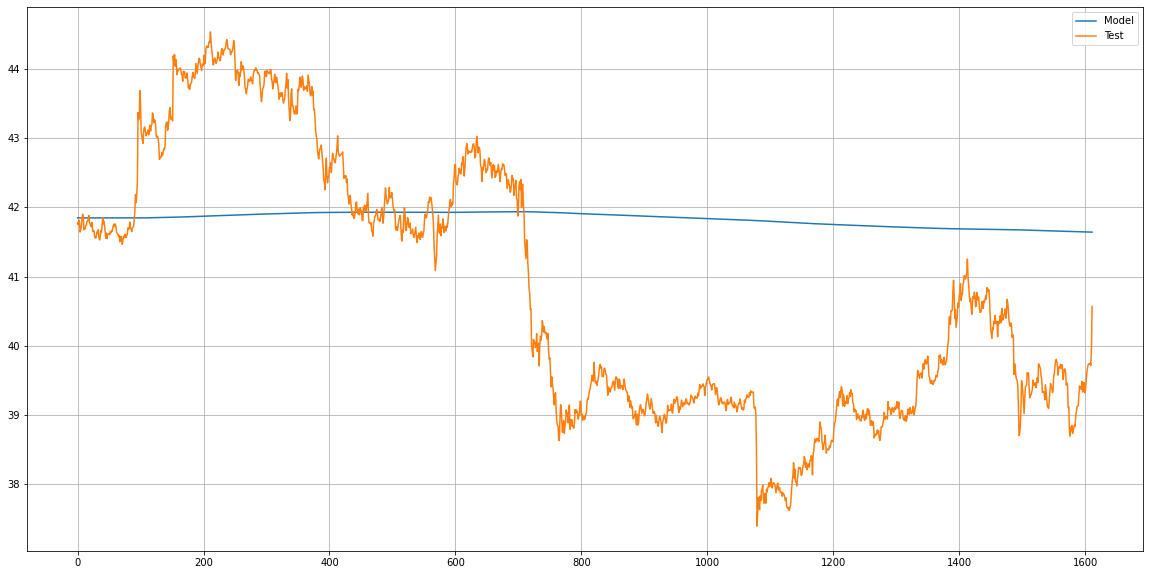

1.8103171985735418

In [ ]:
cross_validation(train_data, mean_model, mean_absolute_error, step = 100)

Сезонный метод

In [ ]:
def seasonal_model(data: pd.DataFrame, season_period: int = 100) -> float:
    #if season_period > len(data - 1):
    #    print('you are naive!')
    #    return data['mean_bid'].iloc[-1]
    return data['mean_bid'].iloc[-season_period]

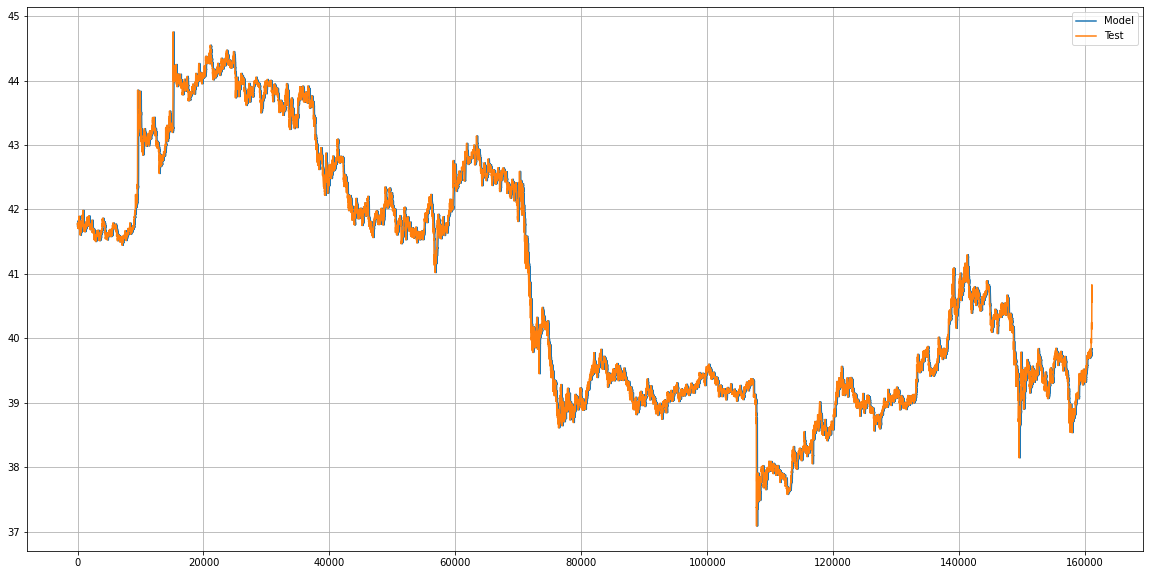

0.09893885614480231

In [ ]:
cross_validation(train_data, seasonal_model, mean_absolute_error, step = 1)

Линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression

def Linear_model(data: pd.DataFrame) -> float:
    model = LinearRegression().fit(np.array(data.index).reshape((-1,1)), data.iloc[:])
    result = model.coef_[0][0]*(train_data.index[-1] + 60) + model.intercept_[0]
    return result

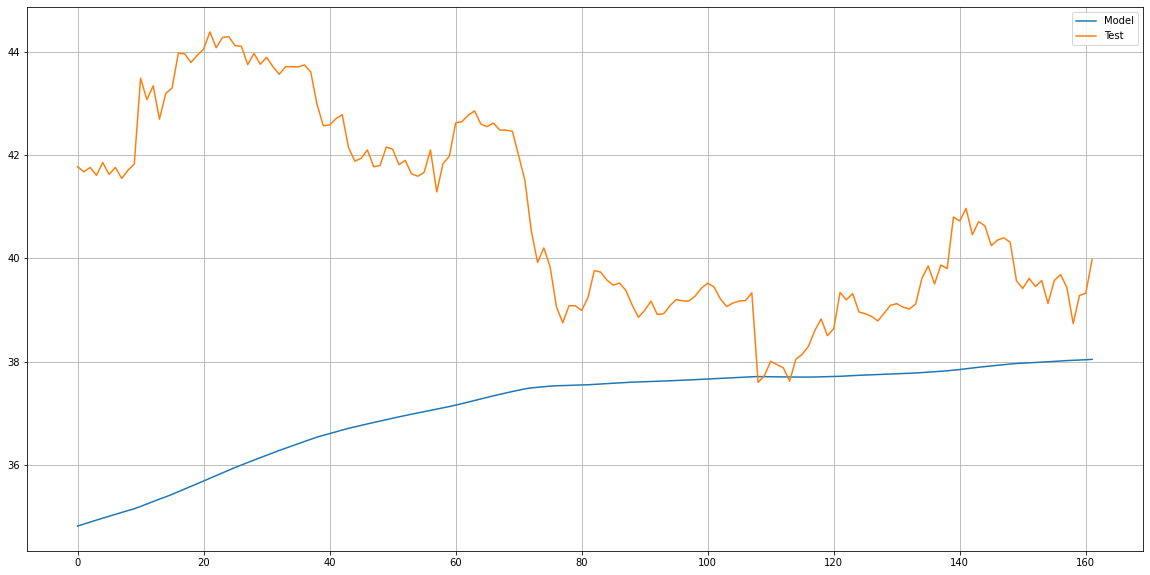

3.730704939621955

In [ ]:
cross_validation(train_data, Linear_model, mean_absolute_error, step = 1000)

Almost

In [ ]:
def Almost_Linear_model(data: pd.DataFrame) -> float:
    model = LinearRegression().fit(np.array(data.index[:]).reshape((-1,1)), data.iloc[:])
    result = model.coef_[0][0]*(60) + data['mean_bid'].iloc[-1] 
    return result

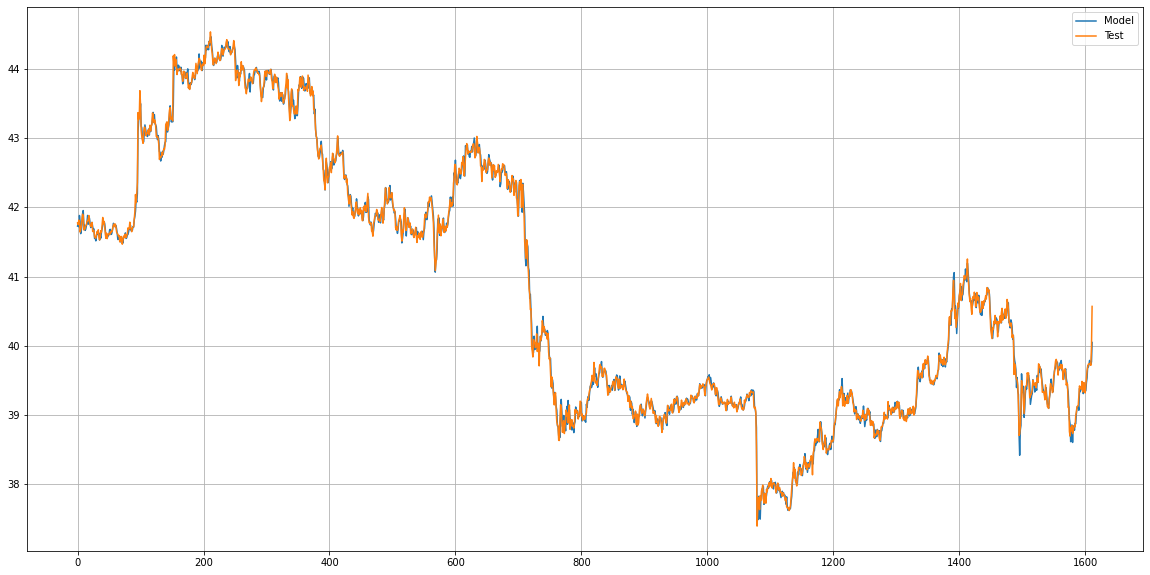

0.05804974757546884

In [ ]:
cross_validation(train_data, Almost_Linear_model, mean_absolute_error, step = 100)

In [ ]:
Bid_mean_DataFrame.tail()

,mean_bid
seconds,
1299995,30.777000
1299996,30.777000
1299997,30.780052
1299998,30.786015
1299999,30.804518


In [ ]:
Almost_Linear_model(Bid_mean_DataFrame)

30.803861585654914

In [ ]:
model = LinearRegression().fit(np.array(Bid_mean_DataFrame.index[:]).reshape((-1,1)), Bid_mean_DataFrame.iloc[:])
result = model.coef_[0][0]*(60) + Bid_mean_DataFrame['mean_bid'].iloc[-1]

In [ ]:
model.coef_[0][0]

-1.0937858132283166e-05

In [ ]:
-1.0937858132283166e-05 * 60

-0.0006562714879369899

In [ ]:
0.058660891464135445-0.05804974757546884

0.0006111438886666071

just a test

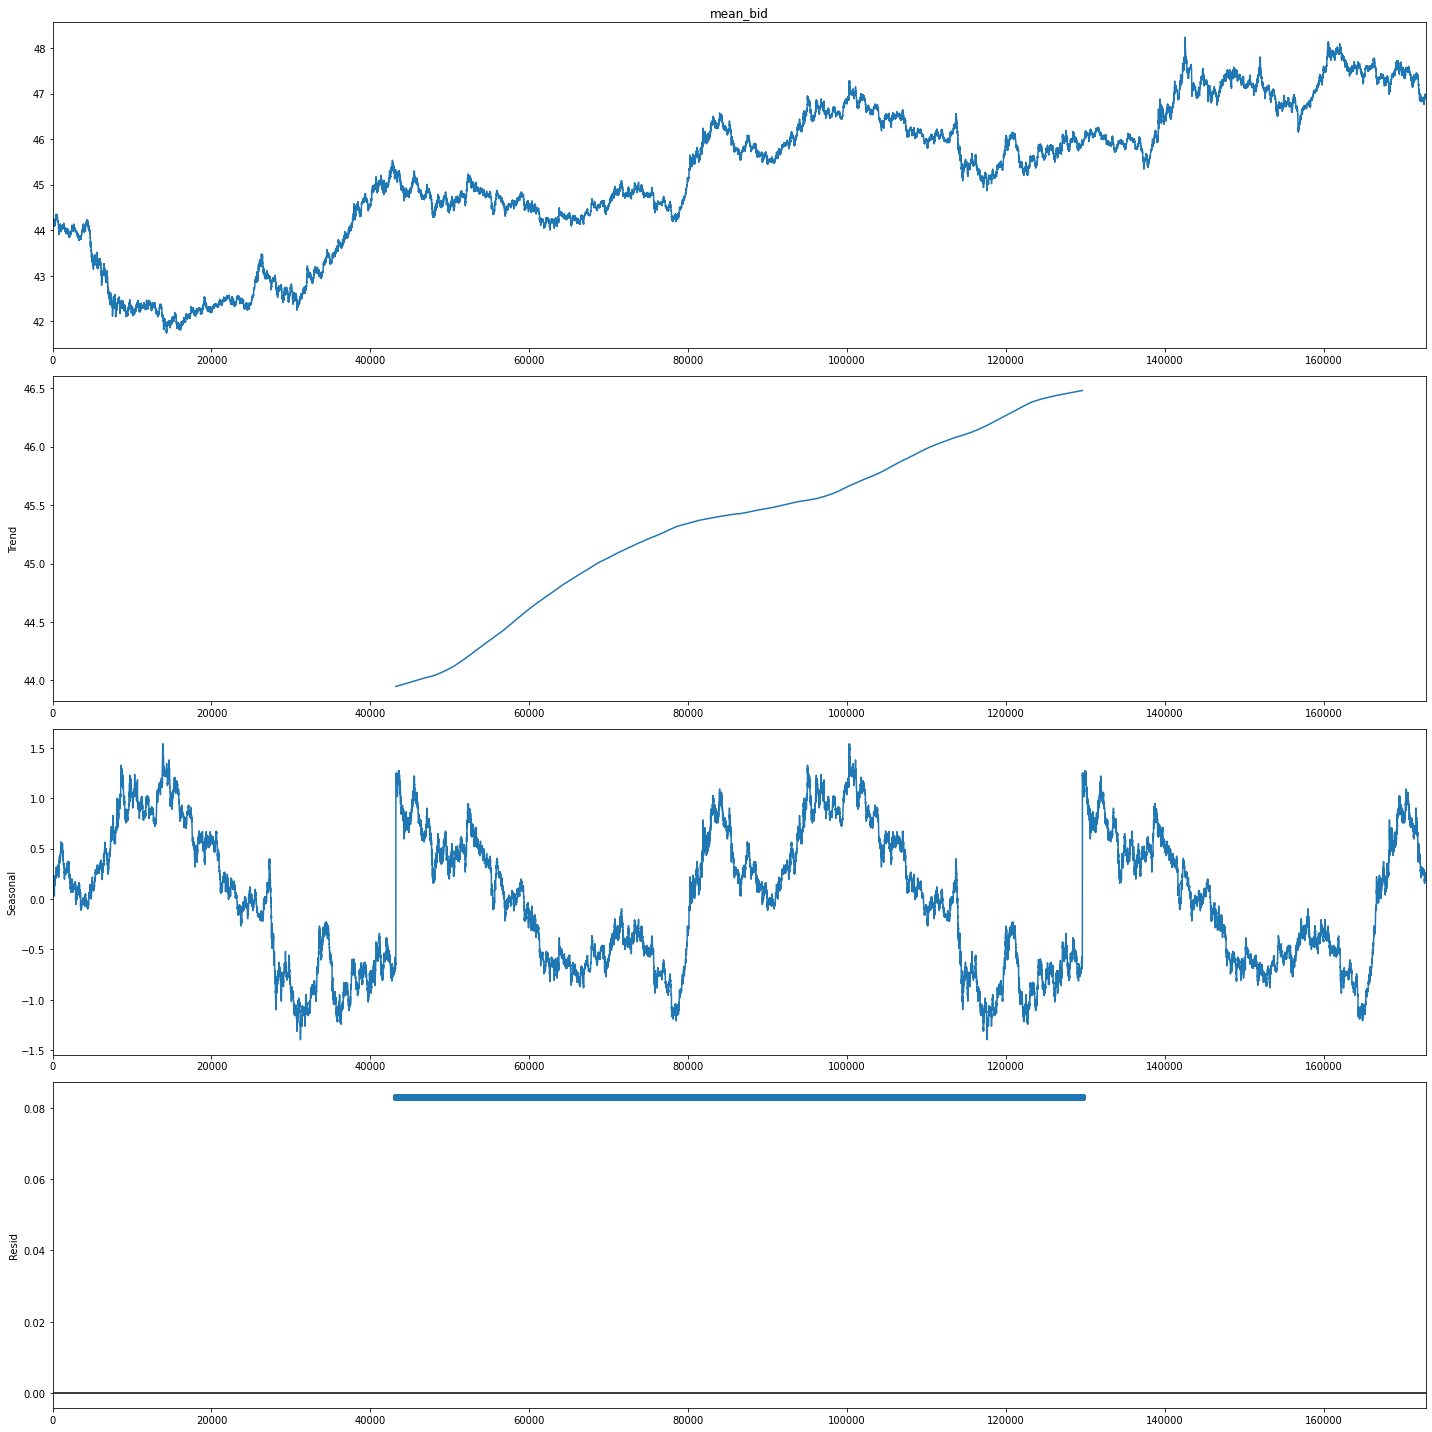

In [ ]:
import statsmodels as sm
rcParams['figure.figsize'] = 20,20
fr = 60*60*24
decomposition = sm.tsa.seasonal.seasonal_decompose(train_data.mean_bid,
                                period = fr,
                                model='additive' ) # additive seasonal index
fig = decomposition.plot()
plt.show()